## Name Prediction Based Bigram

#### 1. 项目简介

本项目旨在通过 PyTorch 动手实现一个经典的 **N-gram** 语言模型。从最简单的 **Bigram（二元模型）** 入手，通过两种不同的方法来构建和训练模型：

1.  **基于统计计数的方法**：传统且直观的方法，通过统计语料库中字符对（bigrams）的出现频率来构建一个概率转换矩阵。
2.  **基于神经网络的方法**：使用一个简单的神经网络（仅包含一个嵌入层）来模拟和学习 Bigram 的概率分布。

最终，我们将使用训练好的模型来生成新的、看起来像名字的字符序列，并比较两种方法的最终损失，以评估它们的效果。

**数据集:** 我们将使用一个包含约32,000个名字的文本文件 `names.txt` 作为我们的语料库。数据集来源([makemore](https://github.com/karpathy/makemore/blob/master/names.txt))

In [210]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# 设置随机种子确保结果可复现
torch.manual_seed(1337)

# 读取数据
with open('names.txt', 'r', encoding='utf-8') as f:
    words = f.read().splitlines()

print(f"数据集大小: {len(words)}")
# display the first 5 rows
print(words[:5])


数据集大小: 32033
['emma', 'olivia', 'ava', 'isabella', 'sophia']


#### 2. 数据准备与预处理

在构建模型之前，首先对数据进行加载和预处理。这个过程主要包含以下几个步骤：

1.  **加载数据**：从 `names.txt` 文件中读取所有名字。
2.  **构建词汇表 (Vocabulary)**：统计所有名字中出现的唯一字符，形成“词汇表”。为了标识序列的开始和结束，我们人为地加入一个特殊字符 `.`。
3.  **创建字符映射**：为了让计算机能够处理字符，我们创建两个映射字典：
    * `stoi` (string to integer): 将每个字符映射到一个唯一的整数索引。
    * `itos` (integer to string): 将整数索引映射回对应的字符，方便我们后续解读模型输出。

In [195]:
# 提取所有唯一字符
chars = sorted(list(set(''.join(words))))
# 添加特殊标记'.'表示开始/结束
chars.insert(0, '.')
vocab_size = len(chars)

print(f"字符集: {''.join(chars)}")
print(f"词汇表大小: {vocab_size}")

# 创建字符到索引的映射
stoi = {s: i for i, s in enumerate(chars)}  # string to int
itos = {i: s for s, i in stoi.items()}      # int to string

print("字符映射示例:", {ch: stoi[ch] for ch in chars[:5]})


字符集: .abcdefghijklmnopqrstuvwxyz
词汇表大小: 27
字符映射示例: {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4}


#### 3. 构建训练样本

对于 Bigram 模型而言，我们的目标是根据当前字符预测下一个字符。因此，我们需要将原始文本数据转换成成对的训练样本 (x, y)，其中 `x` 是当前字符，`y` 是目标下一个字符。

例如，对于名字 "emma"，添加特殊的开始和结束符，得到序列 `.emma.`。然后从中提取出以下 bigram 对：

- `. -> e`
- `e -> m`
- `m -> m`
- `m -> a`
- `a -> .`

我们将遍历整个数据集，构建出所有的 `(x, y)` 对作为模型的训练数据。

In [212]:
# 创建训练数据 - bigram对
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']  # 添加开始结束标记
    for ch1, ch2 in zip(chs, chs[1:]): # 按照步长为1的窗口滑动
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

print(f"训练样本数量: {len(xs)}")
print("前10个bigram对:")
for i in range(10):
    print(f"{itos[xs[i].item()]} -> {itos[ys[i].item()]}")


训练样本数量: 228146
前10个bigram对:
. -> e
e -> m
m -> m
m -> a
a -> .
. -> o
o -> l
l -> i
i -> v
v -> i


#### 4. 方法一：基于统计计数的 Bigram 模型

这是实现 Bigram 模型最经典的方法。其核心思想是：**下一个字符出现的概率，只取决于当前这一个字符**。

通过一个简单的计数过程来估计这个概率。具体步骤如下：

1.  创建一个 N x N 的矩阵（N为词汇表大小），用于存储每个 bigram (如 "ab", "ac"...) 的出现次数。
2.  遍历我们所有的训练样本对 `(xs, ys)`，并填充这个计数矩阵。
3.  为了避免零概率问题（即某些字符组合从未在训练数据中出现过），我们对计数进行**加一平滑 (Add-one smoothing)**。
4.  将每一行的计数转换为概率。通过将每一行的数值除以该行的总和（即行归一化），我们就能得到一个概率转换矩阵 `P`。矩阵中的 `P[i, j]` 代表了在字符 `i` 之后出现字符 `j` 的概率。

这个矩阵 `P` 就是我们基于统计方法训练出的 Bigram 模型。

In [197]:
# 方法1：基于统计计数的bigram模型
N = torch.zeros((vocab_size, vocab_size), dtype=torch.int32)

# 统计bigram出现次数
for x, y in zip(xs, ys):
    N[x, y] += 1

# 计算概率矩阵
P = (N + 1).float()  # 加1平滑避免零概率
P = P / P.sum(1, keepdim=True)  # 行归一化

print("统计矩阵形状:", N.shape)
print("概率矩阵示例:")
print(P[0])  # 显示'.'后面字符的概率分布


统计矩阵形状: torch.Size([27, 27])
概率矩阵示例:
tensor([3.1192e-05, 1.3759e-01, 4.0767e-02, 4.8129e-02, 5.2745e-02, 4.7785e-02,
        1.3038e-02, 2.0898e-02, 2.7293e-02, 1.8465e-02, 7.5577e-02, 9.2452e-02,
        4.9064e-02, 7.9195e-02, 3.5777e-02, 1.2321e-02, 1.6095e-02, 2.9008e-03,
        5.1154e-02, 6.4130e-02, 4.0830e-02, 2.4641e-03, 1.1759e-02, 9.6070e-03,
        4.2109e-03, 1.6719e-02, 2.9008e-02])


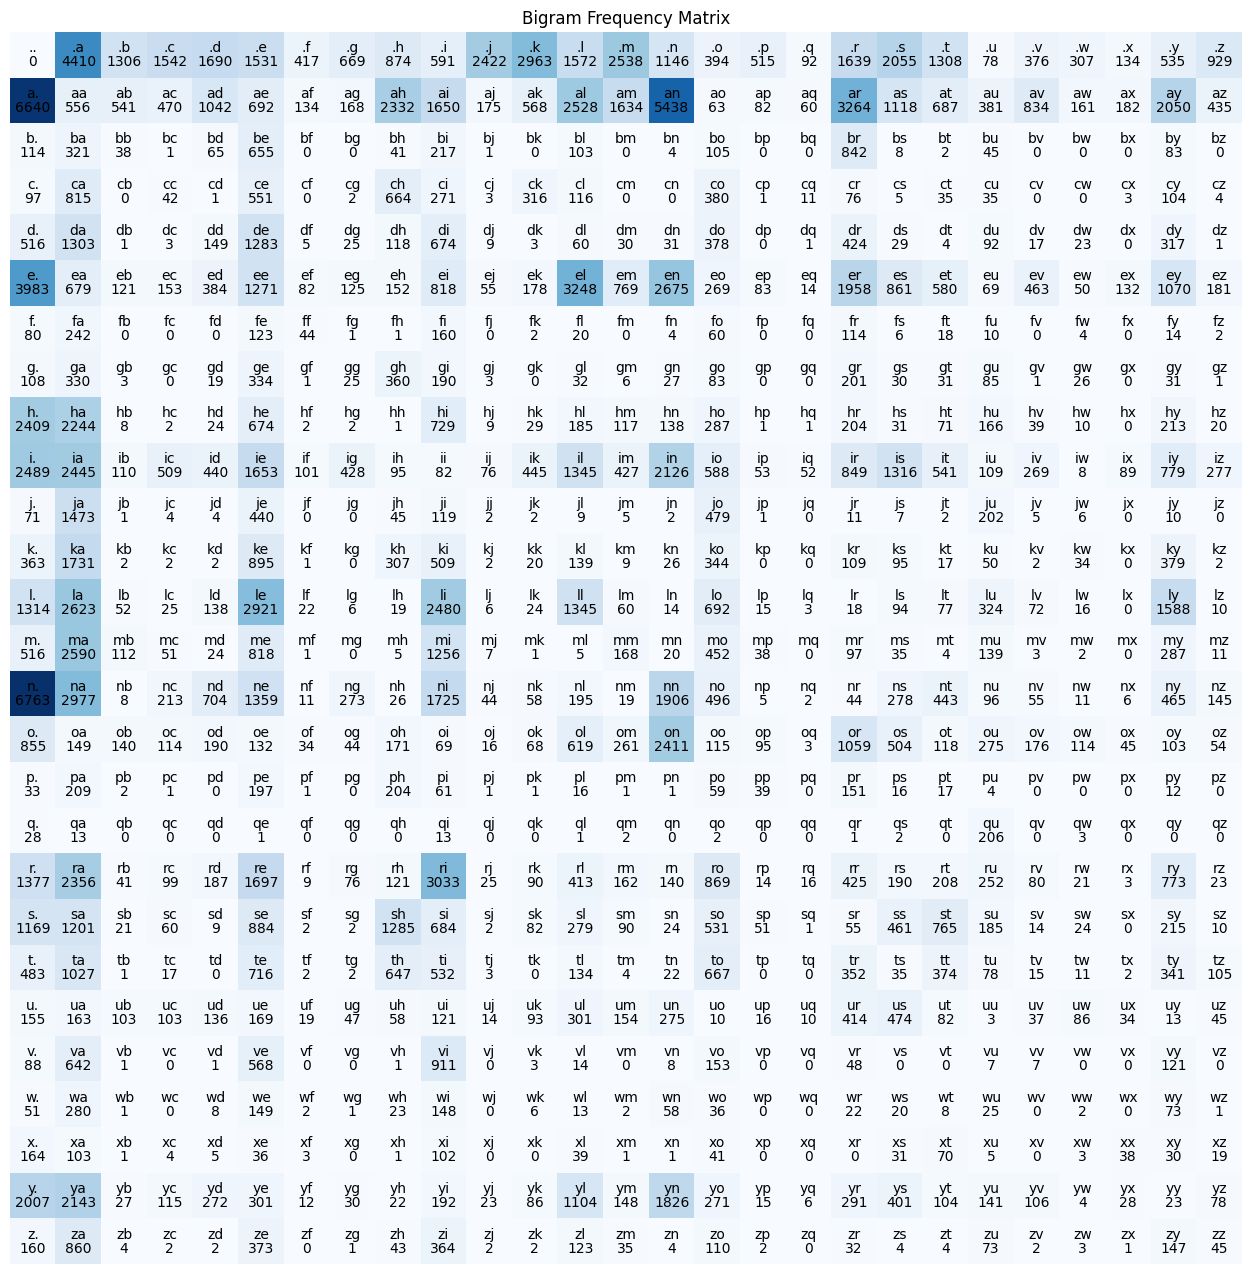

In [214]:
# 可视化bigram频率矩阵
plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')
for i in range(vocab_size):
    for j in range(vocab_size):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='black')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='black')
plt.axis('off')
plt.title("Bigram Frequency Matrix")
plt.show()


通过可视化这个频率矩阵，我们可以直观地看到哪些字符组合在数据集中更常见。例如，`.` 字符所在的第一行代表了名字最可能以哪些字母开头。

---

#### 5. 方法二：神经网络实现的 Bigram 模型

用神经网络的思维方式来重新构建同样的目标。虽然对于 Bigram 这个问题来说，神经网络显得有些“杀鸡用牛刀”，这里使用一个简单的模型，可以帮助我们理解嵌入层（Embedding Layer）和损失函数（Cross-Entropy Loss）的工作原理。

##### 模型架构

我们的神经网络模型非常简单，只包含一个核心组件：
- **`nn.Embedding(vocab_size, vocab_size)`**: 这是一个嵌入层。通常，嵌入层的第二个参数（嵌入维度）会远小于词汇表大小，用于学习一个低维的、包含语义的向量表示。在本项目中，巧妙地将其 **嵌入维度也设置为 `vocab_size`**。

**为什么这样做？**
因为我们希望这个嵌入层直接学习出 Bigram 的概率转换表。当输入一个字符的索引 `i` 时，我们希望模型直接输出一个长度为 `vocab_size` 的向量，这个向量的每一个元素可以被看作是词汇表中对应字符作为下一个字符的**原始得分（logits）**。

这个 `token_embedding_table` 本身就等价于方法一中通过统计得到的概率矩阵 `P`。它就是一个需要通过梯度下降来学习的、尺寸为 `vocab_size x vocab_size` 的参数矩阵。

##### 核心方法
- `forward(idx, targets)`:
  1.  接收一批输入字符索引 `idx` 和对应的目标字符索引 `targets`。
  2.  通过嵌入层查找，得到预测的 `logits`。
  3.  使用 `F.cross_entropy` 计算损失。这个损失函数会衡量模型预测的 `logits` 和真实目标 `targets` 之间的差距，并指导模型参数（即嵌入表里的权重）如何更新。

- `generate(idx, max_new_tokens)`:
  这是一个用于从模型生成新文本的辅助函数。它采用自回归（auto-regressive）的方式，即：
  1.  根据当前字符（或序列）预测下一个字符的 `logits`。
  2.  将 `logits` 通过 `softmax` 转换为概率分布。
  3.  从这个分布中**采样**出下一个字符。
  4.  将新生成的字符拼接到当前序列末尾，作为下一次预测的输入。
  5.  重复此过程，直到生成了指定数量的字符或遇到结束符 `.`。

In [ ]:
# 方法2：神经网络实现
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # 使用嵌入层替代one-hot编码 构建词表
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size) # num of vocab, dim per letter 
    
    def forward(self, idx, targets=None):
        # idx: (B, T) 输入序列
        # targets: (B, T) 目标序列
        logits = self.token_embedding_table(idx)  # (B, T, C)
        
        if targets is None:
            loss = None
        else:
            # 处理不同维度的情况
            if logits.dim() == 2:  # (N, C) - bigram训练情况
                loss = F.cross_entropy(logits, targets)
            else:  # (B, T, C) - 序列情况
                B, T, C = logits.shape
                logits = logits.view(B*T, C)
                targets = targets.view(B*T)
                loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, _ = self(idx)
            logits = logits[:, -1, :]  # 取最后一个时间步
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

# 初始化模型
model = BigramLanguageModel(vocab_size)
print(f"模型参数数量: {sum(p.numel() for p in model.parameters())}")


模型参数数量: 729


可以看到，这个神经网络模型的参数数量恰好是 `27 * 27 = 729`，这正是我们的嵌入表（或说概率转换矩阵）的大小。

##### 训练模型
我们使用 AdamW 优化器，并设置一个相对较大的学习率，因为我们的模型非常简单。训练循环将重复100次（epochs），在每个周期中：
1.  执行前向传播，计算 `logits` 和 `loss`。
2.  清空上一轮的梯度 (`optimizer.zero_grad()`)。
3.  执行反向传播，计算梯度 (`loss.backward()`)。
4.  使用优化器更新模型参数 (`optimizer.step()`)。

In [ ]:
# 训练配置
optimizer = torch.optim.AdamW(model.parameters(), lr=50)

# 训练循环
for epoch in range(100):
    # 前向传播
    logits, loss = model(xs, ys)
    
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

print(f"最终训练损失: {loss.item():.4f}")

Epoch 0: Loss = 6.0486
Epoch 10: Loss = 36.1589
Epoch 20: Loss = 15.6210
Epoch 30: Loss = 7.8783
Epoch 40: Loss = 5.1039
Epoch 50: Loss = 4.7129
Epoch 60: Loss = 4.7135
Epoch 70: Loss = 4.7226
Epoch 80: Loss = 5.2815
Epoch 90: Loss = 5.4422
最终训练损失: 5.6867


#### 6. 结果评估与比较

训练完成后需要评估两个模型的效果。一个好的语言模型应该对其在训练中见过的数据（即整个数据集）赋予较高的概率。负对数似然损失（Negative Log-Likelihood Loss）是衡量这一点的绝佳指标，它越低，说明模型性能越好。

- **统计方法损失**: 直接使用计算出的概率矩阵 `P` 来计算整个数据集的负对数似然。
- **神经网络损失**: 使用训练好的神经网络模型计算整个数据集的交叉熵损失。

结果显示，**基于统计计数的方法获得了更低的损失**。这是符合预期的，因为对于 Bigram 这个简单的问题，直接统计频率并归一化得出的概率分布，就是理论上最优的解。而神经网络通过梯度下降是在**逼近**这个最优解，因此最终结果会略差一些，但已经非常接近了。

这个对比清晰地展示了两种方法的特点：统计方法直观且能得到最优解，而神经网络方法则更加灵活，能够通过学习逼近复杂的数据分布，为解决更高级的NLP任务（如机器翻译、文本摘要等）提供了强大的框架。

In [205]:
# 计算模型在整个数据集上的负对数似然
@torch.no_grad()
def calculate_loss(model, xs, ys):
    logits, loss = model(xs, ys)
    return loss.item()
def calculate_loss_statistical(P, xs, ys):
    """计算统计方法的损失"""
    log_likelihood = 0.0
    for x, y in zip(xs, ys):
        prob = P[x, y]
        log_likelihood += torch.log(prob)
    return -log_likelihood / len(xs)

# 比较统计方法和神经网络方法
stat_loss = calculate_loss_statistical(P, xs, ys)
nn_loss = calculate_loss(model, xs, ys)

print(f"统计方法损失: {stat_loss:.4f}")
print(f"神经网络损失: {nn_loss:.4f}")



统计方法损失: 2.4544
神经网络损失: 5.4343


#### 7. 模型应用：生成新名字

最后用训练好的神经网络模型来生成新的名字！

通过从起始符 `.` 开始，并不断地从模型预测的概率分布中进行采样，我们可以创造出全新的、符合从数据集中学到的模式的字符序列。虽然这些名字大多是无意义的，但它们的拼写风格在某种程度上模仿了真实的名字。

In [206]:
# 使用训练好的模型生成新的名字
@torch.no_grad()
def generate_names(model, num_samples=10):
    model.eval()
    names = []
    
    for _ in range(num_samples):
        name = []
        context = torch.tensor([[stoi['.']]])  # 从'.'开始
        
        while True:
            logits, _ = model(context)
            logits = logits[0, -1, :]  # 取最后位置的logits
            probs = F.softmax(logits, dim=0)
            
            # 采样下一个字符
            next_char_idx = torch.multinomial(probs, num_samples=1).item()
            
            if next_char_idx == 0:  # 遇到'.'结束
                break
                
            name.append(itos[next_char_idx])
            context = torch.tensor([[next_char_idx]])
        
        names.append(''.join(name))
    
    return names

# 生成示例
generated_names = generate_names(model, 10)
print("生成的名字:")
for i, name in enumerate(generated_names):
    print(f"{i+1}: {name}")


生成的名字:
1: ahawdirjeruriruandimandharice
2: ae
3: aisiolymahanere
4: a
5: dikamaw
6: erut
7: arerulandisshamarnigikaherudibiahancerue
8: s
9: andidiss
10: arern




#### 8. 总结与展望

通过这个项目：
1.  亲手实现了两种不同方法的 Bigram 语言模型。
2.  深入理解了 `nn.Embedding` 层如何可以被巧妙地用作一个可学习的概率查找表。
3.  对比了统计方法和神经网络方法在解决简单NLP任务上的优劣。

这个项目是自然语言处理入门的一个很好的起点。下一步，可以尝试构建更复杂的 **Trigram (三元)** 甚至更高阶的 N-gram 模型，或者引入更多的神经网络层（如线性层和激活函数）来提升模型的学习能力.